In [1]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from pandas.tseries.holiday import USFederalHolidayCalendar

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

features = queries.get_profit_ces_qty_by_day(server, schema)
features.describe().transpose()

count           mean           std         min            25%  \
TYEAR   1304.0    2018.009202      1.413098   2016.0000    2017.000000   
TMON    1304.0       6.512270      3.444528      1.0000       4.000000   
TDAY    1304.0      15.783742      8.749828      1.0000       8.000000   
PROFIT  1304.0  217462.198385  80415.107225 -15223.8972  172522.205450   
CES     1304.0   40188.634781  13823.630222      0.0000   32105.969020   
QTY     1304.0   34993.188450  12268.689575      0.0000   27582.166666   

                50%            75%            max  
TYEAR     2018.0000    2019.000000    2021.000000  
TMON         7.0000      10.000000      12.000000  
TDAY        16.0000      23.000000      31.000000  
PROFIT  218742.5641  268125.288775  549121.795700  
CES      40183.7799   48502.275385   96539.687250  
QTY      34749.8750   42437.989584   88468.166667

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

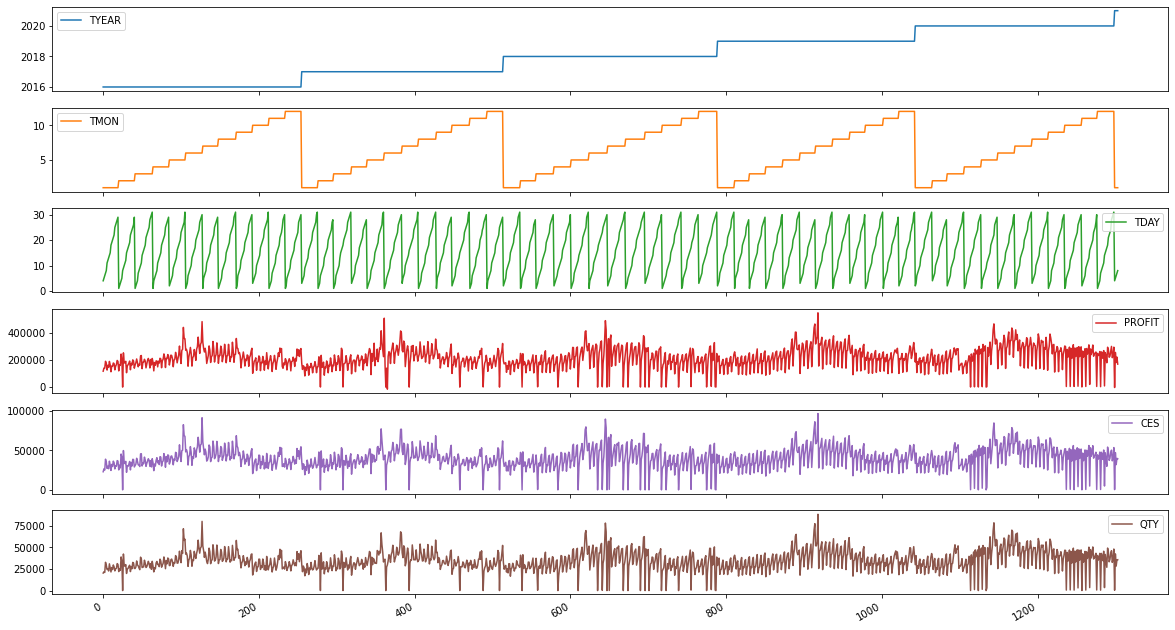

In [3]:
features.plot(subplots=True, figsize=(20, 12))

array([<AxesSubplot:xlabel='DATE'>], dtype=object)

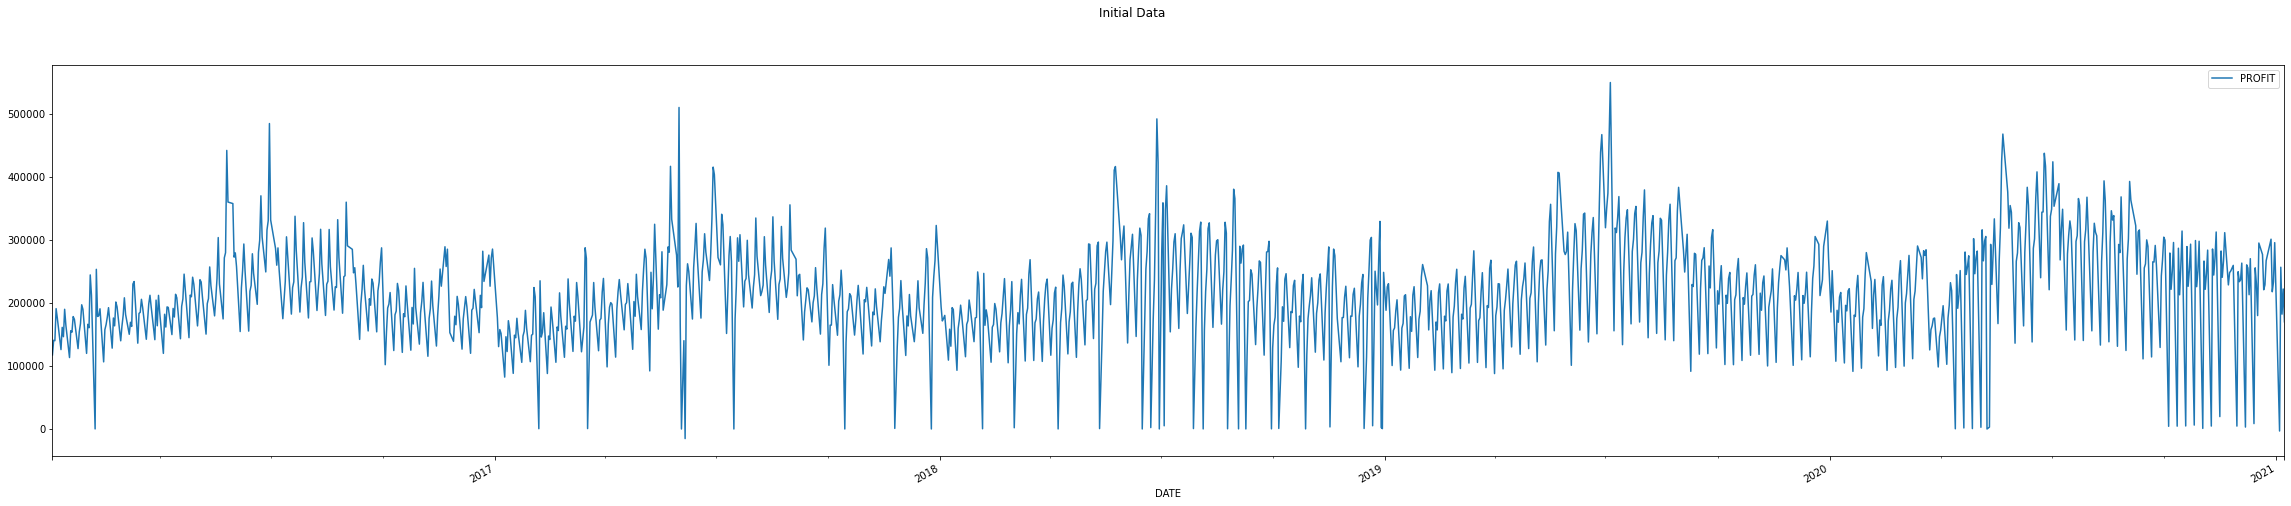

In [4]:
# Combine individual date columns to single index
df = features.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.drop(columns=['YEAR', 'MONTH', 'DAY', 'QTY', 'CES'])
df.set_index('DATE', inplace=True)

# Insert zeros for missing dates
# df = add_missing_dates(df)
df.index = pd.DatetimeIndex(df.index).to_period('d')
df.plot(subplots=True, title='Initial Data', figsize=(40,8))

In [5]:
from statsmodels.tsa.arima.model import ARIMA

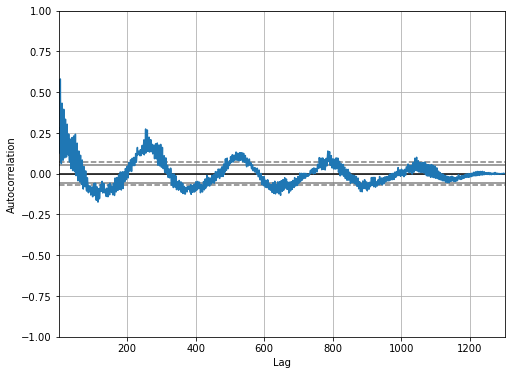

In [6]:
pd.plotting.autocorrelation_plot(df)
plt.show()

In [7]:
model = ARIMA(df, order=(75, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 PROFIT   No. Observations:                 1304
Model:                ARIMA(75, 0, 0)   Log Likelihood              -16159.827
Date:                Fri, 08 Jan 2021   AIC                          32473.653
Time:                        07:44:54   BIC                          32871.989
Sample:                    01-04-2016   HQIC                         32623.087
                         - 01-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.175e+05   9282.236     23.428      0.000    1.99e+05    2.36e+05
ar.L1          0.1882      0.025      7.487      0.000       0.139       0.237
ar.L2          0.0024      0.029      0.082      0.9

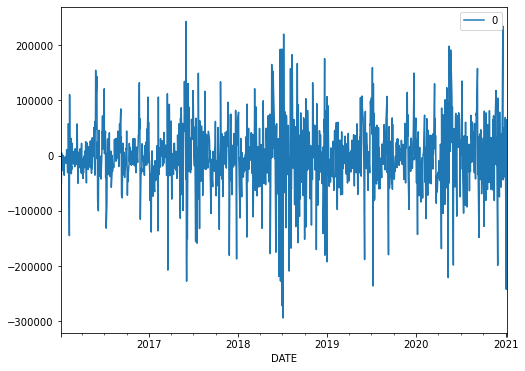

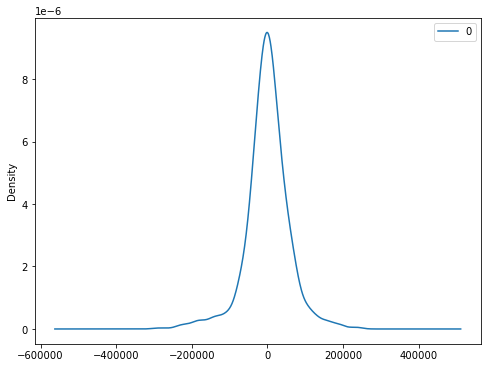

                   0
count    1304.000000
mean      -70.400999
std     58234.376608
min   -293878.167216
25%    -25878.822474
50%       328.818385
75%     28120.566048
max    242647.853988


In [8]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [29]:
def add_lag(df):
    lags = [1, 2, 3, 4, 5, 6, 7]
    cols = df.columns

    lagged = df.assign(**{
        '{} (t-{})'.format(col, t): df[col].shift(t)
        for t in lags
        for col in cols
    })

    return lagged.dropna()

def add_missing_dates(df):
    missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
    n = len(missing_dates)
    m = len(df.columns)
    missing_dates_data = np.zeros((n,m))
    missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
    dfs = [df, missing_dates_df]
    df = pd.concat(dfs)
    df['Date'] = df.index
    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    return df

def reshape(X):
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    return X

[[117472.2012    22910.60025   20316.416667]
 [140594.5397    26593.65424   21790.25    ]
 [139909.615     25070.76044   21007.666667]
 ...
 [ -3207.3158      326.9715      393.416667]
 [256366.8644    47149.36519   42510.666669]
 [181991.7177    31930.20691   28387.000001]]
[[ 0.84056682]
 [ 0.47270842]
 [ 0.52362943]
 [ 0.77620318]
 [-0.97889933]
 [-0.97889933]
 [-0.97889933]
 [ 1.        ]
 [ 0.45195683]
 [ 0.55469213]
 [ 0.96406691]
 [-0.97889933]
 [-0.97889933]
 [-0.97889933]
 [-1.        ]
 [ 0.70771751]
 [ 0.21840944]
 [ 0.18273701]]


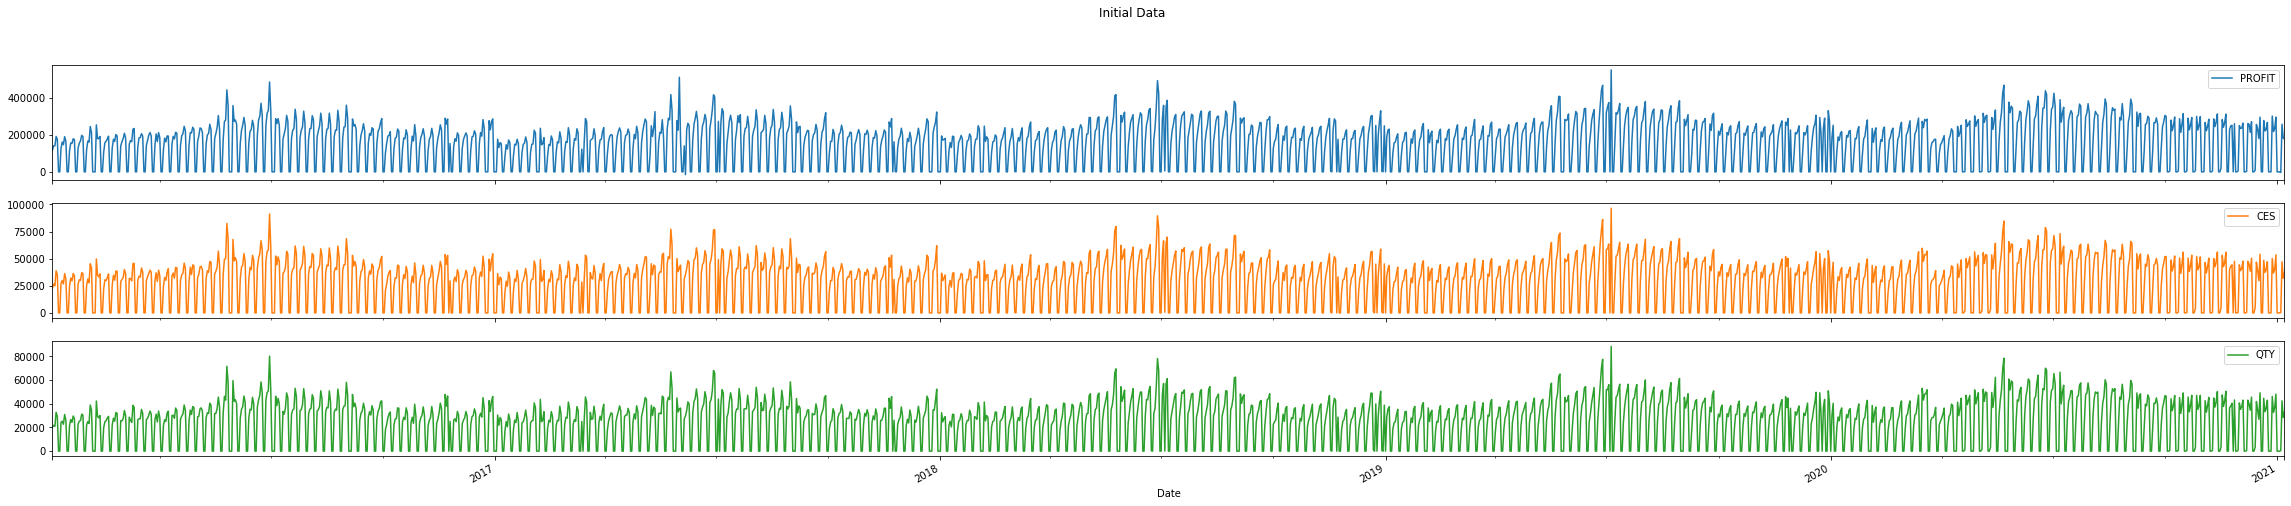

In [48]:
tss = TimeSeriesSplit(n_splits=100)

# Combine individual date columns to single index
df = features.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
df.set_index('DATE', inplace=True)

# Insert zeros for missing dates
df = add_missing_dates(df)
df.plot(subplots=True, title='Initial Data', figsize=(40,8))

df_lag = add_lag(df)

X = df_lag.filter(regex='t-')
Y = df_lag.filter(regex='^(PROFIT$)')

X = df.values
n_train = 50
n_records = len(X)
for i in range(n_train, n_records):
    X_train, X_test = X[0:i], X[i:i+1]
#     print('train=%d, test=%d' % (len(train), len(test)))

# for train_index, test_index in tss.split(X):
#     X_train, X_test = X.iloc[test_index,:], X.iloc[train_index,:]
#     Y_train, Y_test = Y.iloc[test_index], Y.iloc[train_index]
    
print(X_train)
print(Y_train)
    
# Normalize Data
scalerX = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
scalerY = MinMaxScaler(feature_range=(-1,1)).fit(Y_train)
X_train = scalerX.transform(X_train)
Y_train = scalerY.transform(Y_train)
X_test = scalerX.transform(X_test)
Y_test = scalerY.transform(Y_test)

In [49]:
MONITOR = 'val_loss'
PATIENCE = 50
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
EPOCHS = 50
CALLBACKS = [ES]
VERBOSE = 2

model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

In [50]:
# Reshape Data
X_train = reshape(X_train)
X_test = reshape(X_test)

# Compile model    
model.compile(loss=LOSS, optimizer=OPTIMIZER)

# Fit model to training data
history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                    callbacks=CALLBACKS, validation_data=(X_test, Y_test),
                    verbose=VERBOSE, shuffle=False)

# Plot train vs. val losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training Loss vs. Test Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: Data cardinality is ambiguous:
  x sizes: 1830
  y sizes: 18
Make sure all arrays contain the same number of samples.